### Gas Noise Test

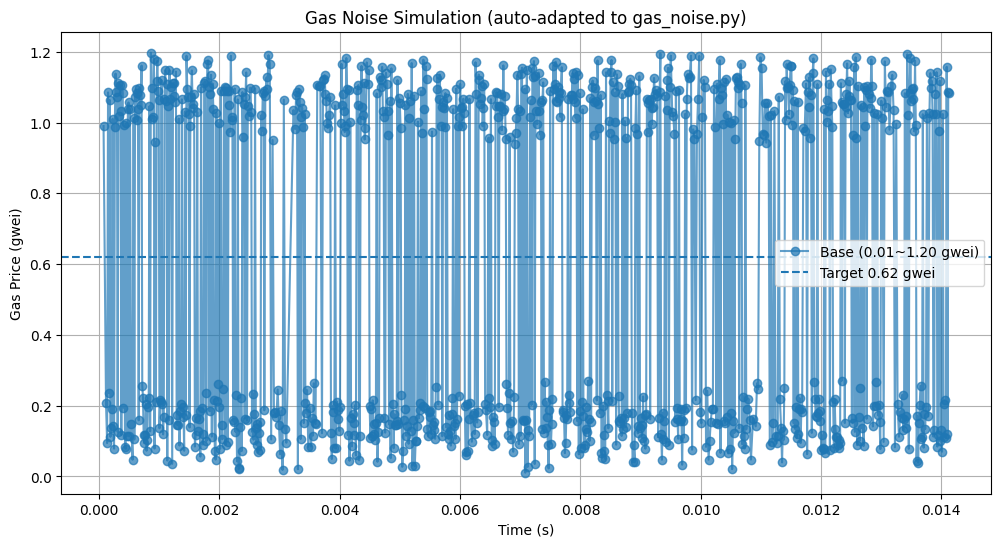

In [1]:
# IPython cell — robust adapter for different gas_noise.py versions

import importlib, inspect
import matplotlib.pyplot as plt
import numpy as np
import gas_noise

# reload in case gas_noise.py was edited on disk
importlib.reload(gas_noise)

def run_and_plot(min_gwei, max_gwei, *,
                 steps=200, seed=None, label=None,
                 edge_width=0.22, sigma_frac=0.05, switch_period=0,
                 interval_min=0.0, interval_max=0.0):
    min_wei = int(min_gwei * 1e9)
    max_wei = int(max_gwei * 1e9)

    # Base kwargs (common to most versions)
    kwargs = dict(
        min_gas=min_wei,
        max_gas=max_wei,
        steps=steps,
        switch_period=switch_period,
        interval_min=interval_min,   # 0 -> no sleep
        interval_max=interval_max,   # 0 -> no sleep
        seed=seed,
        write_toml=False,
        verbose=False,
    )

    # Adapt to function signature
    params = inspect.signature(gas_noise.generate_gas_sequence).parameters

    # Handle edge/sigma names (new anti-normal versions)
    if 'edge_width_frac' in params:
        kwargs['edge_width_frac'] = edge_width
    elif 'edge_width' in params:
        kwargs['edge_width'] = edge_width

    if 'sigma_frac' in params:
        kwargs['sigma_frac'] = sigma_frac

    # If this is an older Beta-U version, fall back to its API
    if 'model' in params and 'beta_alpha' in params:
        # Switch to the beta_u path; remove anti-normal-specific kwargs
        kwargs.update(model='beta_u', beta_alpha=0.5, beta_beta=0.5)
        kwargs.pop('edge_width_frac', None)
        kwargs.pop('edge_width', None)
        kwargs.pop('sigma_frac', None)

    prices, times = gas_noise.generate_gas_sequence(**kwargs)
    prices_gwei = np.array(prices) / 1e9
    plt.plot(times, prices_gwei, marker='o', alpha=0.7, label=label)

# --- demo ---
plt.figure(figsize=(12, 6))
run_and_plot(
    0.01, 1.20,
    steps=1000,
    seed=5,
    label='Base (0.01~1.20 gwei)',
    edge_width=0.22,
    sigma_frac=0.05,
    switch_period=12,
    interval_min=0.0,  # no real sleep in notebooks
    interval_max=0.0
)
plt.axhline(0.62, linestyle='--', label='Target 0.62 gwei')
plt.xlabel('Time (s)'); plt.ylabel('Gas Price (gwei)')
plt.title('Gas Noise Simulation (auto-adapted to gas_noise.py)')
plt.legend(); plt.grid(True); plt.show()


### 获取网络数据

In [2]:
# ---------------- Request ----------------
import os
from dataclasses import dataclass, asdict
from botasaurus.request import request, Request, NotFoundException

import importlib
import basescan
importlib.reload(basescan)
from basescan import TxListRequest, fetch_latest_gas_price

MONITOR_ADDRESSES = [
    "0x58db69748e3597e7e1ec55478a6edb92374169f0",
    "0x5c18226fdE960dBDe7EA1e19124d63b2d590a4D1"
]

results = fetch_latest_gas_price([TxListRequest(addr, offset=1000) for addr in MONITOR_ADDRESSES])

Running
[INFO]::[0x58db69748e3597e7e1ec55478a6edb92374169f0] [tx: 55.80%] [error: 20.43%] (114 | 558 | 1000)
[INFO]::[0x5c18226fdE960dBDe7EA1e19124d63b2d590a4D1] [tx: 81.20%] [error: 76.23%] (619 | 812 | 1000)
Written
     output/fetch_latest_gas_price.json


In [3]:
import pandas as pd
grouped = {address: pd.DataFrame(tx_list) for address, tx_list in zip(MONITOR_ADDRESSES, results) if tx_list}

[INFO]::[low] | min=10590175 | max=30544521 | mean=25037354.03 | median=24050529.0 | std=3757799.84 | mad=2236921.50 | iqr=5807677.75 | variance=14121059605713.79
[INFO]::[mid] | min=30546356 | max=506917939 | mean=85796809.10 | median=53269413.0 | std=111079019.46 | mad=21951255.00 | iqr=43764956.75 | variance=12338548563418036.00
[INFO]::[high] | min=509415647 | max=1788325553 | mean=988458012.54 | median=807489037.5 | std=415250889.88 | mad=270046823.00 | iqr=709721388.75 | variance=172433301547838080.00
[INFO]::[low] | min=17902032 | max=23679214 | mean=22490594.54 | median=22682312.0 | std=1084712.69 | mad=259261.00 | iqr=713310.00 | variance=1176601619954.58
[INFO]::[mid] | min=23682816 | max=155736544 | mean=65344560.18 | median=46659126.0 | std=43174345.49 | mad=22869049.00 | iqr=68025478.50 | variance=1864024108112780.75
[INFO]::[high] | min=155738538 | max=1788031283 | mean=1137941979.26 | median=1393388753.0 | std=528342159.98 | mad=162735640.00 | iqr=700805400.50 | variance

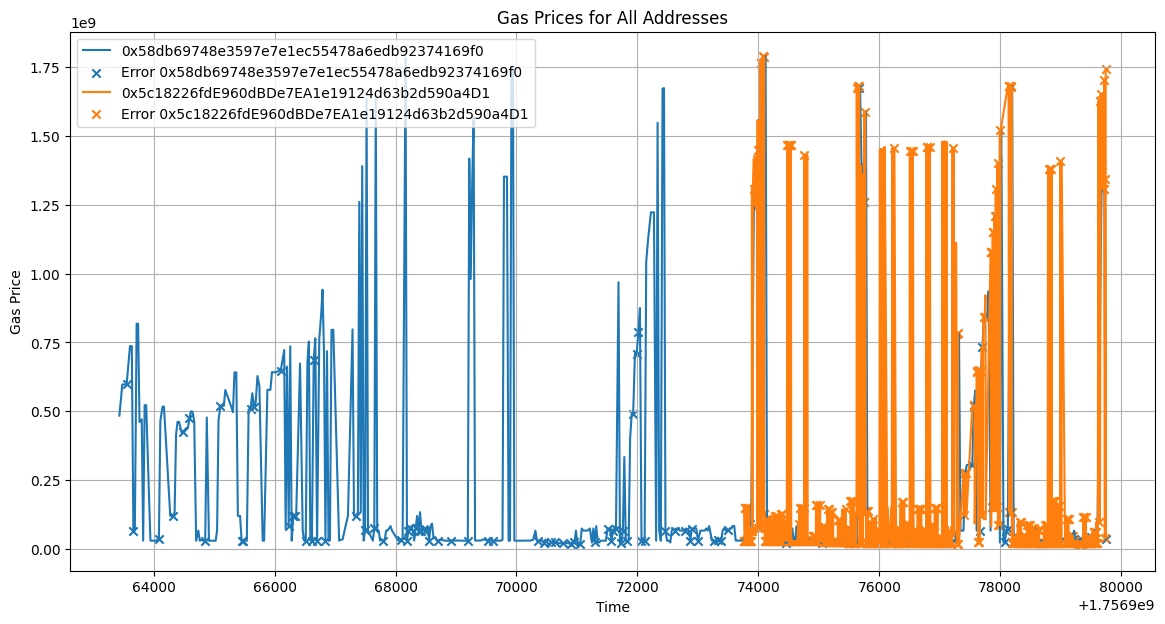

In [12]:
import matplotlib.pyplot as plt
import itertools

import basescan
importlib.reload(basescan)
from basescan import analyze_gas_prices

colors = itertools.cycle(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'])
plt.figure(figsize=(14, 7))
for address, df in grouped.items():
    df_time_sorted = df.sort_values('time_stamp')
    analyze_gas_prices(df_time_sorted)
    # time filter example
    start_time, end_time = None, None
    if start_time is not None:
        df_time_sorted = df_time_sorted[df_time_sorted['time_stamp'] >= start_time]
    if end_time is not None:
        df_time_sorted = df_time_sorted[df_time_sorted['time_stamp'] <= end_time]
    color = next(colors)
    plt.plot(df_time_sorted['time_stamp'], df_time_sorted['gas_prices'], label=f'{address}', color=color)
    plt.scatter(df_time_sorted[df_time_sorted['is_error']]['time_stamp'], df_time_sorted[df_time_sorted['is_error']]['gas_prices'], color=color, marker='x', label=f'Error {address}')
plt.xlabel('Time')
plt.ylabel('Gas Price')
plt.legend()
plt.grid(True)
plt.title('Gas Prices for All Addresses')
plt.show()

### 反正态分布

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def anti_normal_gas_iter(min_gas, max_gas, n_samples, edge_width=0.13, mid_gas=None):
    time_points = np.linspace(0, 100, n_samples)
    uniform_samples = np.random.uniform(-1, 1, n_samples)
    transformed_samples = np.sign(uniform_samples) * (1 - np.power(1 - np.abs(uniform_samples), 1/edge_width))
    if mid_gas is None:
        mid_gas = (min_gas + max_gas) / 2
    half_range = (max_gas - min_gas) / 2
    for t, s in zip(time_points, transformed_samples):
        yield t, mid_gas + s * half_range


test_mid_gas = 0.3
data1 = anti_normal_gas_iter(0.1, 1.0, 1000, edge_width=0.17, mid_gas=test_mid_gas)
data2 = anti_normal_gas_iter(0.1, 1.0, 1000, edge_width=0.17)  # 默认居中

t1, g1 = zip(*data1)
t2, g2 = zip(*data2)

plt.figure(figsize=(12, 6))
plt.scatter(t1, g1, alpha=0.6, s=5, label=f'mid_gas={test_mid_gas}')
plt.scatter(t2, g2, alpha=0.6, s=5, label='mid_gas=None')
plt.xlabel('time')
plt.ylabel('Gas Price')
plt.title('Anti-Normal Distribution Comparison')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.hist(g1, bins=50, alpha=0.6, label=f'mid_gas={test_mid_gas}')
plt.hist(g2, bins=50, alpha=0.6, label='mid_gas=None')
plt.xlabel('Gas Price (gwei)')
plt.ylabel('Frequency')
plt.title('Gas Price Distribution Histogram Comparison')
plt.legend()
plt.grid(True)
plt.show()